# 4 Kfold 0.989

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, datasets
from torchvision.models import efficientnet_b0, efficientnet_b5, EfficientNet_B5_Weights
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import cv2
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold

# =============================================================================
# 1. FUNGSI HELPER DAN PENGATURAN SEED
# =============================================================================

def set_seed(seed):
    """
    Fungsi untuk mengatur random seed agar hasil eksperimen reproducible.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # jika menggunakan multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Panggil fungsi ini sekali di awal skrip Anda
SEED = 42  # Angka 42 adalah konvensi, bisa diganti angka lain
set_seed(SEED)

print(f"Random seed diatur ke {SEED}")

# =============================================================================
# 2. DEFINISI MODEL, DATASET, DAN FUNGSI HELPER
# =============================================================================

# --- DEFINISI MODUL CBAM (ATTENTION) ---

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        x = self.ca(x) * x
        x = self.sa(x) * x
        return x

# --- DEFINISI MODEL EFFICIENTNET DENGAN CBAM ---

class EfficientNetB5_CBAM(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetB5_CBAM, self).__init__()
        # Muat model EfficientNet B5 pre-trained
        self.base_model = efficientnet_b5(weights=EfficientNet_B5_Weights.IMAGENET1K_V1)
        
        # Hapus lapisan classifier asli
        self.features = self.base_model.features
        
        # Tambahkan modul CBAM setelah blok fitur utama
        # Fitur output dari EfficientNet-B5 adalah 2048
        self.attention = CBAM(in_planes=2048)
        
        self.avgpool = self.base_model.avgpool
        
        # Buat classifier baru
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.attention(x)  # Terapkan attention di sini
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# --- DEFINISI MODEL DENSENET (CHEXNET) ---

class CheXNetModel(nn.Module):
    """
    Model berbasis DenseNet untuk klasifikasi multi-class, kompatibel dengan CheXNet weights.
    """
    def __init__(self, num_classes, pretrained=True, checkpoint_path=None):
        super(CheXNetModel, self).__init__()
        
        # Load DenseNet sebagai backbone
        self.densenet = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=pretrained)
        
        # Ganti classifier untuk multi-class
        num_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, num_classes)
        )
        
        # Load pre-trained weights jika tersedia
        if checkpoint_path and os.path.exists(checkpoint_path):
            self.load_pretrained_weights(checkpoint_path, num_classes)
    
    def load_pretrained_weights(self, checkpoint_path, num_classes):
        """
        Load pre-trained weights dan adaptasi untuk jumlah kelas yang berbeda.
        """
        try:
            if os.path.isdir(checkpoint_path):
                for file in os.listdir(checkpoint_path):
                    if file.endswith(('.pth', '.pt')):
                        checkpoint_path = os.path.join(checkpoint_path, file)
                        break
            
            if checkpoint_path.endswith(('.pth', '.pt')):
                checkpoint = torch.load(checkpoint_path, map_location='cpu')
                
                if 'state_dict' in checkpoint:
                    state_dict = checkpoint['state_dict']
                elif 'model' in checkpoint:
                    state_dict = checkpoint['model']
                else:
                    state_dict = checkpoint
                
                new_state_dict = {}
                for k, v in state_dict.items():
                    name = k[7:] if k.startswith('module.') else k
                    new_state_dict[name] = v
                
                model_dict = self.densenet.state_dict()
                pretrained_dict = {k: v for k, v in new_state_dict.items() 
                                 if k in model_dict and 'classifier' not in k}
                
                model_dict.update(pretrained_dict)
                self.densenet.load_state_dict(model_dict, strict=False)
                print(f"Pre-trained weights loaded from {checkpoint_path}")
                
        except Exception as e:
            print(f"Could not load pre-trained weights: {e}")
            print("Using ImageNet pre-trained weights instead.")
    
    def forward(self, x):
        return self.densenet(x)

# --- FUNGSI UNTUK MEMILIH MODEL ---

def get_model(architecture_name, num_classes, checkpoint_path=None):
    if architecture_name == 'densenet':
        return CheXNetModel(num_classes=num_classes, pretrained=True, checkpoint_path=checkpoint_path)
    elif architecture_name == 'efficientnet':
        print("-> Menggunakan EfficientNet-B5 dengan CBAM Attention.")
        return EfficientNetB5_CBAM(num_classes=num_classes)
    else:
        raise ValueError("Architecture not supported")

# --- DEFINISI DATASET CUSTOM ---

class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, is_test=False):
        self.root_dir = root_dir
        self.transform = transform
        self.is_test = is_test
        
        if not is_test:
            self.dataset = datasets.ImageFolder(root_dir)
            self.samples = self.dataset.samples
            self.classes = self.dataset.classes
        else:
            self.image_paths = []
            for file in sorted(os.listdir(root_dir)):
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(root_dir, file))
    
    def __len__(self):
        if self.is_test:
            return len(self.image_paths)
        return len(self.samples)
    
    def __getitem__(self, idx):
        if self.is_test:
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, os.path.basename(img_path)
        else:
            img_path, label = self.samples[idx]
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label

# --- CUSTOM TRANSFORM UNTUK CLAHE ---

class ApplyCLAHE(object):
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
        self.clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)

    def __call__(self, img):
        img_np = np.array(img)  # Convert PIL Image to NumPy array
        if len(img_np.shape) == 3 and img_np.shape[2] == 3:  # Check if RGB image
            lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
            l, a, b = cv2.split(lab)
            l_clahe = self.clahe.apply(l)
            lab_clahe = cv2.merge((l_clahe, a, b))
            img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)
            return Image.fromarray(img_clahe)
        else:
            gray_clahe = self.clahe.apply(img_np)
            return Image.fromarray(gray_clahe)

# =============================================================================
# 3. KONFIGURASI DAN PERSIAPAN DATA
# =============================================================================

# Atur parameter utama
IMG_SIZE = (384, 384)
BATCH_SIZE = 16
EPOCHS = 15
LEARNING_RATE = 0.001
NUM_FOLDS = 4

# Path ke direktori data
TRAIN_PATH = "/kaggle/input/final-srifoton-25-machine-learning-competition/train/train"
TEST_PATH = "/kaggle/input/final-srifoton-25-machine-learning-competition/test/test"
CHEXNET_WEIGHTS = '/kaggle/input/chexnet-weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5'

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

train_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    ApplyCLAHE(clip_limit=2.0),  # Kontras X-ray
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(
        degrees=10,               # rotasi kecil ±10°
        translate=(0.05, 0.05),   # translasi ≤5% per sumbu
        scale=(0.95, 1.05),       # skala ringan 0.95–1.05
        shear=(-5, 5, -5, 5),     # shear ringan pada x & y
        interpolation=InterpolationMode.BILINEAR,
        fill=0                    # isi tepi hitam
    ),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    ApplyCLAHE(clip_limit=2.0),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Create full train dataset
print("Loading full train dataset...")
full_train_dataset = ImageDataset(TRAIN_PATH, transform=None)  # Load without transform for splitting

# Get class names
class_names = full_train_dataset.classes
num_classes = len(class_names)
print(f"Classes found: {class_names}")
print(f"Number of classes: {num_classes}")

# Get paths and labels for splitting
samples = full_train_dataset.samples
paths, labels = zip(*samples)
labels = np.array(labels)

# Prepare Stratified K-Fold
skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)

# Test dataset
test_dataset = ImageDataset(TEST_PATH, transform=val_test_transform, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, 
                         shuffle=False, num_workers=4)

print(f"Test batches: {len(test_loader)}")

# =============================================================================
# 4. MEMBUAT DAN MELATIH MODEL DENGAN STRATIFIED K-FOLD
# =============================================================================

# Pilih arsitektur model
architecture = 'efficientnet'  # Ganti ke 'densenet' jika ingin menggunakan CheXNet

# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')
    return epoch_loss, epoch_acc, epoch_f1

# Validation function
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')
    return epoch_loss, epoch_acc, epoch_f1

# Loss function
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# List to store best models paths and validation metrics
model_paths = []
fold_val_accs = []
fold_val_f1s = []

for fold, (train_idx, val_idx) in enumerate(skf.split(paths, labels)):
    print(f"\n--- Fold {fold + 1}/{NUM_FOLDS} ---")
    
    # Create subsets
    train_subset = Subset(ImageDataset(TRAIN_PATH, transform=train_transform), train_idx)
    val_subset = Subset(ImageDataset(TRAIN_PATH, transform=val_test_transform), val_idx)
    
    # Data loaders
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    
    print(f"Train batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    
    # Create model
    model = get_model(architecture, num_classes=num_classes, checkpoint_path=CHEXNET_WEIGHTS)
    model = model.to(device)
    
    # --- TAHAP 1: PEMANASAN (TRAIN CLASSIFIER HEAD SAJA) ---
    print("\n--- Starting Stage 1: Training Classifier Head ---")
    
    # Bekukan semua lapisan kecuali classifier dan attention (untuk EfficientNet)
    if architecture == 'efficientnet':
        for param in model.features.parameters():
            param.requires_grad = False
        for param in model.avgpool.parameters():
            param.requires_grad = False
        for param in model.attention.parameters():
            param.requires_grad = True  # Latih modul CBAM
        for param in model.classifier.parameters():
            param.requires_grad = True
    else:
        for param in model.densenet.features.parameters():
            param.requires_grad = False
        for param in model.densenet.classifier.parameters():
            param.requires_grad = True
    
    # Optimizer for head
    optimizer_head = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=LEARNING_RATE
    )
    epochs_head = 5
    
    for epoch in range(epochs_head):
        print(f"\nHead Training Epoch [{epoch+1}/{epochs_head}]")
        train_loss, train_acc, train_f1 = train_epoch(model, train_loader, criterion, optimizer_head, device)
        val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, criterion, device)
        print(f"Head Train Loss: {train_loss:.4f}, Head Train Acc: {train_acc:.2f}%, Head Train F1: {train_f1:.4f}")
        print(f"Head Val Loss: {val_loss:.4f}, Head Val Acc: {val_acc:.2f}%, Head Val F1: {val_f1:.4f}")
    
    # --- TAHAP 2: PENYEMPURNAAN (TRAIN SELURUH MODEL) ---
    print("\n--- Starting Stage 2: Fine-tuning Full Model ---")
    
    # Unfreeze all layers
    for param in model.parameters():
        param.requires_grad = True
    
    # Optimizer for full model
    optimizer_full = optim.AdamW(model.parameters(), lr=LEARNING_RATE / 10, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_full, mode='max', factor=0.5, patience=3, verbose=True)
    
    # Training loop
    train_losses, train_accs, train_f1s = [], [], []
    val_losses, val_accs, val_f1s = [], [], []
    best_val_acc = 0.0
    patience_counter = 0
    patience = 7
    
    for epoch in range(EPOCHS):
        print(f"\nEpoch [{epoch+1}/{EPOCHS}]")
        
        train_loss, train_acc, train_f1 = train_epoch(model, train_loader, criterion, optimizer_full, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        train_f1s.append(train_f1)
        
        val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_f1s.append(val_f1)
        
        scheduler.step(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val F1: {val_f1:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_path = f'best_model_fold{fold+1}.pth'
            torch.save(model.state_dict(), best_model_path)
            patience_counter = 0
            print(f"New best validation accuracy: {best_val_acc:.2f}%")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
    
    # Save best model path and metrics
    model_paths.append(best_model_path)
    fold_val_accs.append(best_val_acc)
    fold_val_f1s.append(max(val_f1s))  # Best F1 from the fold

# Print average cross-validation metrics
avg_val_acc = np.mean(fold_val_accs)
avg_val_f1 = np.mean(fold_val_f1s)
print(f"\nCross-Validation Results:")
print(f"Average Validation Accuracy: {avg_val_acc:.2f}%")
print(f"Average Validation F1: {avg_val_f1:.4f}")

# =============================================================================
# 5. PLOT TRAINING HISTORY (FOR LAST FOLD AS EXAMPLE)
# =============================================================================

# Note: For simplicity, plotting only the last fold's history
plt.figure(figsize=(18, 5))

# Plot accuracy
plt.subplot(1, 3, 1)
epochs_range = range(1, len(train_accs) + 1)
plt.plot(epochs_range, train_accs, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_accs, label='Validation Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy (Last Fold)')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_losses, label='Training Loss', marker='o')
plt.plot(epochs_range, val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Last Fold)')
plt.legend()
plt.grid(True)

# Plot F1 score
plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_f1s, label='Training Macro F1', marker='o')
plt.plot(epochs_range, val_f1s, label='Validation Macro F1', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Macro F1 Score')
plt.title('Training and Validation Macro F1 Score (Last Fold)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Mengumpulkan prediksi dari validation set (last fold as example)...


Validating: 100%|██████████| 134/134 [00:19<00:00,  6.81it/s]



Classification Report (Last Fold)
                 precision    recall  f1-score   support

          COVID       1.00      0.99      1.00       399
         Normal       1.00      1.00      1.00      1577
Viral Pneumonia       0.99      0.98      0.99       167

       accuracy                           1.00      2143
      macro avg       1.00      0.99      0.99      2143
   weighted avg       1.00      1.00      1.00      2143


Confusion Matrix (Last Fold)


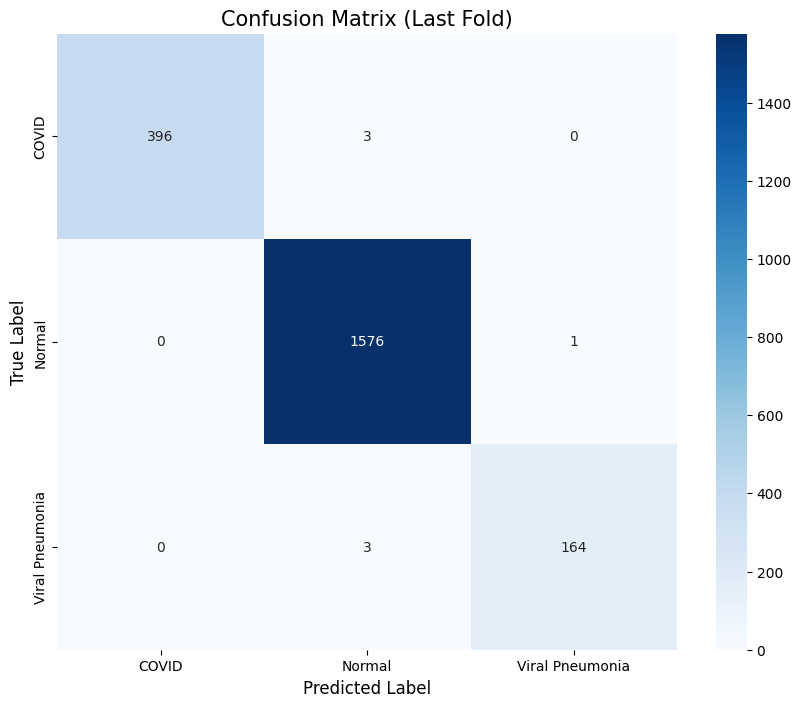

In [11]:
# =============================================================================
# 7. EVALUASI MODEL PADA VALIDATION SET (AVERAGE OVER FOLDS)
# =============================================================================

# For evaluation, we can collect metrics from each fold's best model on its val set
# But since we already have fold_val_accs and fold_val_f1s, we can use those

# For confusion matrix, as example, use the last fold's val set
model = models[-1]  # Last model as example
model.eval()
all_preds = []
all_labels = []

print("Mengumpulkan prediksi dari validation set (last fold as example)...")
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Validating"):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 1. Tampilkan Laporan Klasifikasi
print("\n" + "="*50)
print("Classification Report (Last Fold)")
print("="*50)
print(classification_report(all_labels, all_preds, target_names=class_names))

# 2. Buat dan Tampilkan Confusion Matrix
print("\n" + "="*50)
print("Confusion Matrix (Last Fold)")
print("="*50)
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix (Last Fold)', fontsize=15)
plt.show()

In [ ]:
# =============================================================================
# 6. PROSES PREDIKSI DENGAN TTA DAN ENSEMBLE
# =============================================================================

print("Memulai proses prediksi dengan ensemble...")

# Load all models
models = []
# Pastikan variabel 'model_paths' sudah terdefinisi dan berisi path ke file .pth Anda
# Contoh: model_paths = ['best_model_fold1.pth', 'best_model_fold2.pth']
for path in model_paths:
    # Pastikan 'architecture' dan 'num_classes' sudah terdefinisi sebelumnya
    model = get_model(architecture, num_classes=num_classes, checkpoint_path=CHEXNET_WEIGHTS)
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    model.eval()
    models.append(model)

print(f"✅ Berhasil memuat {len(models)} model untuk ensemble.")

# Definisikan transformasi untuk TTA
base_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    ApplyCLAHE(clip_limit=2.0),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

hflip_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    ApplyCLAHE(clip_limit=2.0),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

rotate_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    ApplyCLAHE(clip_limit=2.0),
    transforms.RandomRotation(degrees=15), # Sedikit tingkatkan derajat rotasi
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

tta_transforms = [base_transform, hflip_transform, rotate_transform]
print(f"Menggunakan {len(tta_transforms)} transformasi untuk TTA per model.")

# --- Dapatkan daftar file gambar tes secara langsung ---
test_image_paths = sorted([os.path.join(TEST_PATH, f) for f in os.listdir(TEST_PATH) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
print(f"Menemukan {len(test_image_paths)} gambar untuk diprediksi dengan TTA dan ensemble.")

# --- Jalankan Prediksi (Iterasi Langsung, Tanpa DataLoader) ---
print("\n🚀 Membuat prediksi pada data tes...")
predictions_indices = []
filenames = []

with torch.no_grad():
    # Iterasi langsung pada list file path
    for image_path in tqdm(test_image_paths, desc="Testing with TTA and Ensemble"):
        current_filename = os.path.basename(image_path)
        current_image = Image.open(image_path).convert('RGB')
        
        ensemble_probs = torch.zeros(1, num_classes).to(device)
        
        # 1. Ensemble Loop (untuk setiap model)
        for model in models:
            tta_probs = torch.zeros(1, num_classes).to(device)
            
            # 2. TTA Loop (untuk setiap transformasi)
            for tta_transform in tta_transforms:
                transformed_image = tta_transform(current_image).unsqueeze(0).to(device)
                outputs = model(transformed_image)
                probs = nn.functional.softmax(outputs, dim=1)
                tta_probs += probs
                
            # Rata-rata probabilitas dari TTA untuk model saat ini
            avg_tta_probs = tta_probs / len(tta_transforms)
            ensemble_probs += avg_tta_probs
        
        # Rata-rata probabilitas dari semua model (ensemble)
        avg_ensemble_probs = ensemble_probs / len(models)
        _, predicted = avg_ensemble_probs.max(1)
        
        predictions_indices.append(predicted.cpu().item())
        filenames.append(current_filename)

# --- Mapping Kelas ke Nomor ---
# Pastikan urutan kelas di sini sama dengan urutan folder saat training
# Misal: class_names = ['COVID', 'Normal', 'Viral Pneumonia']
class_to_number = {
    'COVID': 0,
    'Normal': 1,
    'Viral Pneumonia': 2
}

final_predictions = []
for idx in predictions_indices:
    # Pastikan variabel 'class_names' sudah ada
    class_name = class_names[idx]
    number = class_to_number.get(class_name, -1) 
    final_predictions.append(number)

# Hilangkan ekstensi .png dari filename
filenames_no_ext = [f.split('.')[0] for f in filenames]

# Buat DataFrame untuk submission
results_df = pd.DataFrame({
    'ID': filenames_no_ext,
    'Predicted': final_predictions
})

# Simpan ke file CSV
submission_path = 'submission.csv'
results_df.to_csv(submission_path, index=False)

print(f"\n✅ Prediksi selesai! File disimpan di: {submission_path}")
print("\nPreview 10 prediksi pertama:")
print(results_df.head(10))

print("\nDistribusi prediksi:")
counts = results_df['Predicted'].value_counts().sort_index()
percentages = results_df['Predicted'].value_counts(normalize=True).sort_index() * 100

distribution = pd.DataFrame({
    'Count': counts,
    'Percentage': percentages.round(2)
})
print(distribution)